In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import SVG, display

In [2]:
import pandas as pd
import numpy as np
import os as os
from datetime import datetime
from datetime import date
import seaborn as sb

In [3]:
plt.style.use('ggplot')

In [4]:
files = os.listdir(os.getcwd())
pgpdataG = pd.read_csv('PGP Gender by Enrollment Date.csv')
pgpdataE = pd.read_csv('PGP Ethnicity by Enrollment Date.csv')

In [5]:
pgpdataG['phenotype'] = pgpdataG['phenotype'].apply(lambda x: x.lower())

In [6]:
pgpEnrollbyGenderT = pd.crosstab(pgpdataG['enrollment_date.1'],pgpdataG.phenotype,margins = True)

In [7]:
pgpEnrollbyGender = pd.crosstab(pgpdataG['enrollment_date.1'],pgpdataG.phenotype)
pgpEnrollbyGender.index = pd.to_datetime(pgpEnrollbyGender.index,format='%m/%Y')
pgpEnrollbyGender = pgpEnrollbyGender.sort_index()

In [8]:
pgpEnrollbyGenderRS = pgpEnrollbyGender.resample('MS',how = 'mean')
pgpEnrollbyGenderRS.fillna(0)

pgpEnrollbyGenderRS2 = pgpEnrollbyGenderRS.loc[:,{'male','female'}]
Other = pgpEnrollbyGenderRS.loc[:,{'agender','genderqueer','neutrois','non binary','transmasculine'}]
pgpEnrollbyGenderRS2['other'] = Other.sum(axis=1)

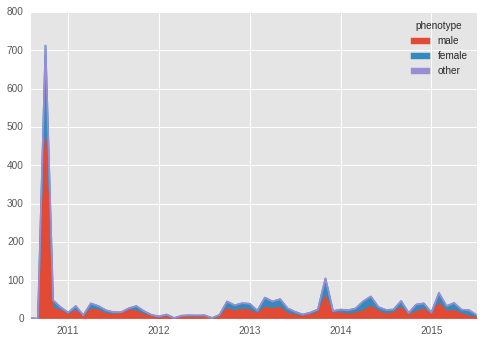

In [9]:
h1 = pgpEnrollbyGenderRS2.plot(kind='area',stacked=True)

In [10]:
totalpgpEnrollbyGender2 = pd.expanding_sum(pgpEnrollbyGenderRS2)

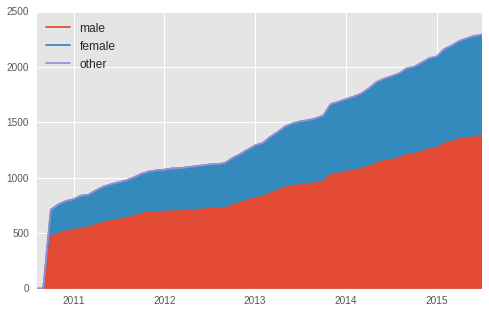

In [11]:
h2 = totalpgpEnrollbyGender2.plot(kind='area',stacked=True)
h2.legend(loc = 'upper left', fontsize = 12)
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig('GenderEnrollment.svg')

In [12]:
plt.savefig("Gender-Enrollment.svg", format="svg")